## Loading of Steinmetz data

includes some visualizations

In [120]:
import math as math
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colormaps
from scipy.stats import zscore
from sklearn.decomposition import PCA

# For progress bars
from tqdm.notebook import tqdm

# Importing Cashaback lab data vizualization package
import data_visualization as dv
wheel = dv.ColorWheel()


In [87]:
# @title Figure settings
from matplotlib import rcParams

# rcParams['figure.figsize'] = [20, 4]
rcParams['font.weight'] = 'bold'
rcParams['font.size'] = 13
rcParams['axes.spines.top'] = False
rcParams['axes.spines.right'] = False
rcParams['figure.autolayout'] = True

In [83]:
# @title Data retrieval
import os, requests

fname = []
for j in range(3):
  fname.append('steinmetz_part%d.npz'%j) #npz files are numpy arrays that are saved using (np.savez)
url = ["https://osf.io/agvxh/download"]
url.append("https://osf.io/uv3mw/download")
url.append("https://osf.io/ehmw2/download")

for j in range(len(url)):
  if not os.path.isfile(fname[j]):
    try:
      r = requests.get(url[j])
    except requests.ConnectionError:
      print("!!! Failed to download data !!!")
    else:
      if r.status_code != requests.codes.ok:
        print("!!! Failed to download data !!!")
      else:
        with open(fname[j], "wb") as fid:
          fid.write(r.content)

In [84]:
# @title Data loading
alldat = np.array([])
for j in tqdm(range(len(fname))):
  alldat = np.hstack((alldat,
                      np.load('steinmetz_part%d.npz'%j,
                              allow_pickle=True)['dat']))

  0%|          | 0/3 [00:00<?, ?it/s]

`alldat` contains 39 sessions from 10 mice, data from Steinmetz et al, 2019. Time bins for all measurements are 10ms, starting 500ms before stimulus onset. The mouse had to determine which side has the highest contrast. For each `dat = alldat[k]`, you have the fields below. For extra variables, check out the extra notebook and extra data files (lfp, waveforms and exact spike times, non-binned).

NB: that the time point data other than the spike (gocue, response_time, etc are all time linked to the stimulus presentation time).

The recordings also just come from the left hemisphere.

* `dat['mouse_name']`: mouse name
* `dat['date_exp']`: when a session was performed
* `dat['spks']`: neurons by trials by time bins.    
* `dat['brain_area']`: brain area for each neuron recorded.
* `dat['ccf']`: Allen Institute brain atlas coordinates for each neuron.
* `dat['ccf_axes']`: axes names for the Allen CCF.
* `dat['contrast_right']`: contrast level for the right stimulus, which is always contralateral to the recorded brain areas.
* `dat['contrast_left']`: contrast level for left stimulus.
* `dat['gocue']`: when the go cue sound was played. (this is relative to 0?)
* `dat['response_time']`: when the response was registered, which has to be after the go cue. The mouse can turn the wheel before the go cue (and nearly always does!), but the stimulus on the screen won't move before the go cue.  
* `dat['response']`: which side the response was (`-1`, `0`, `1`). When the right-side stimulus had higher contrast, the correct choice was `-1`. `0` is a no go response.
* `dat['feedback_time']`: when feedback was provided.
* `dat['feedback_type']`: if the feedback was positive (`+1`, reward) or negative (`-1`, white noise burst).  
* `dat['wheel']`: turning speed of the wheel that the mice uses to make a response, sampled at `10ms`.
* `dat['pupil']`: pupil area  (noisy, because pupil is very small) + pupil horizontal and vertical position.
* `dat['face']`: average face motion energy from a video camera.
* `dat['licks']`: lick detections, 0 or 1.   
* `dat['trough_to_peak']`: measures the width of the action potential waveform for each neuron. Widths `<=10` samples are "putative fast spiking neurons".
* `dat['%X%_passive']`: same as above for `X` = {`spks`, `pupil`, `wheel`, `contrast_left`, `contrast_right`} but for  passive trials at the end of the recording when the mouse was no longer engaged and stopped making responses.
* `dat['prev_reward']`: time of the feedback (reward/white noise) on the previous trial in relation to the current stimulus time.
* `dat['reaction_time']`: ntrials by 2. First column: reaction time computed from the wheel movement as the first sample above `5` ticks/10ms bin. Second column: direction of the wheel movement (`0` = no move detected).  


The original dataset is here: https://figshare.com/articles/dataset/Dataset_from_Steinmetz_et_al_2019/9598406

## Graphing Behavioral Data

  0%|          | 0/214 [00:00<?, ?it/s]

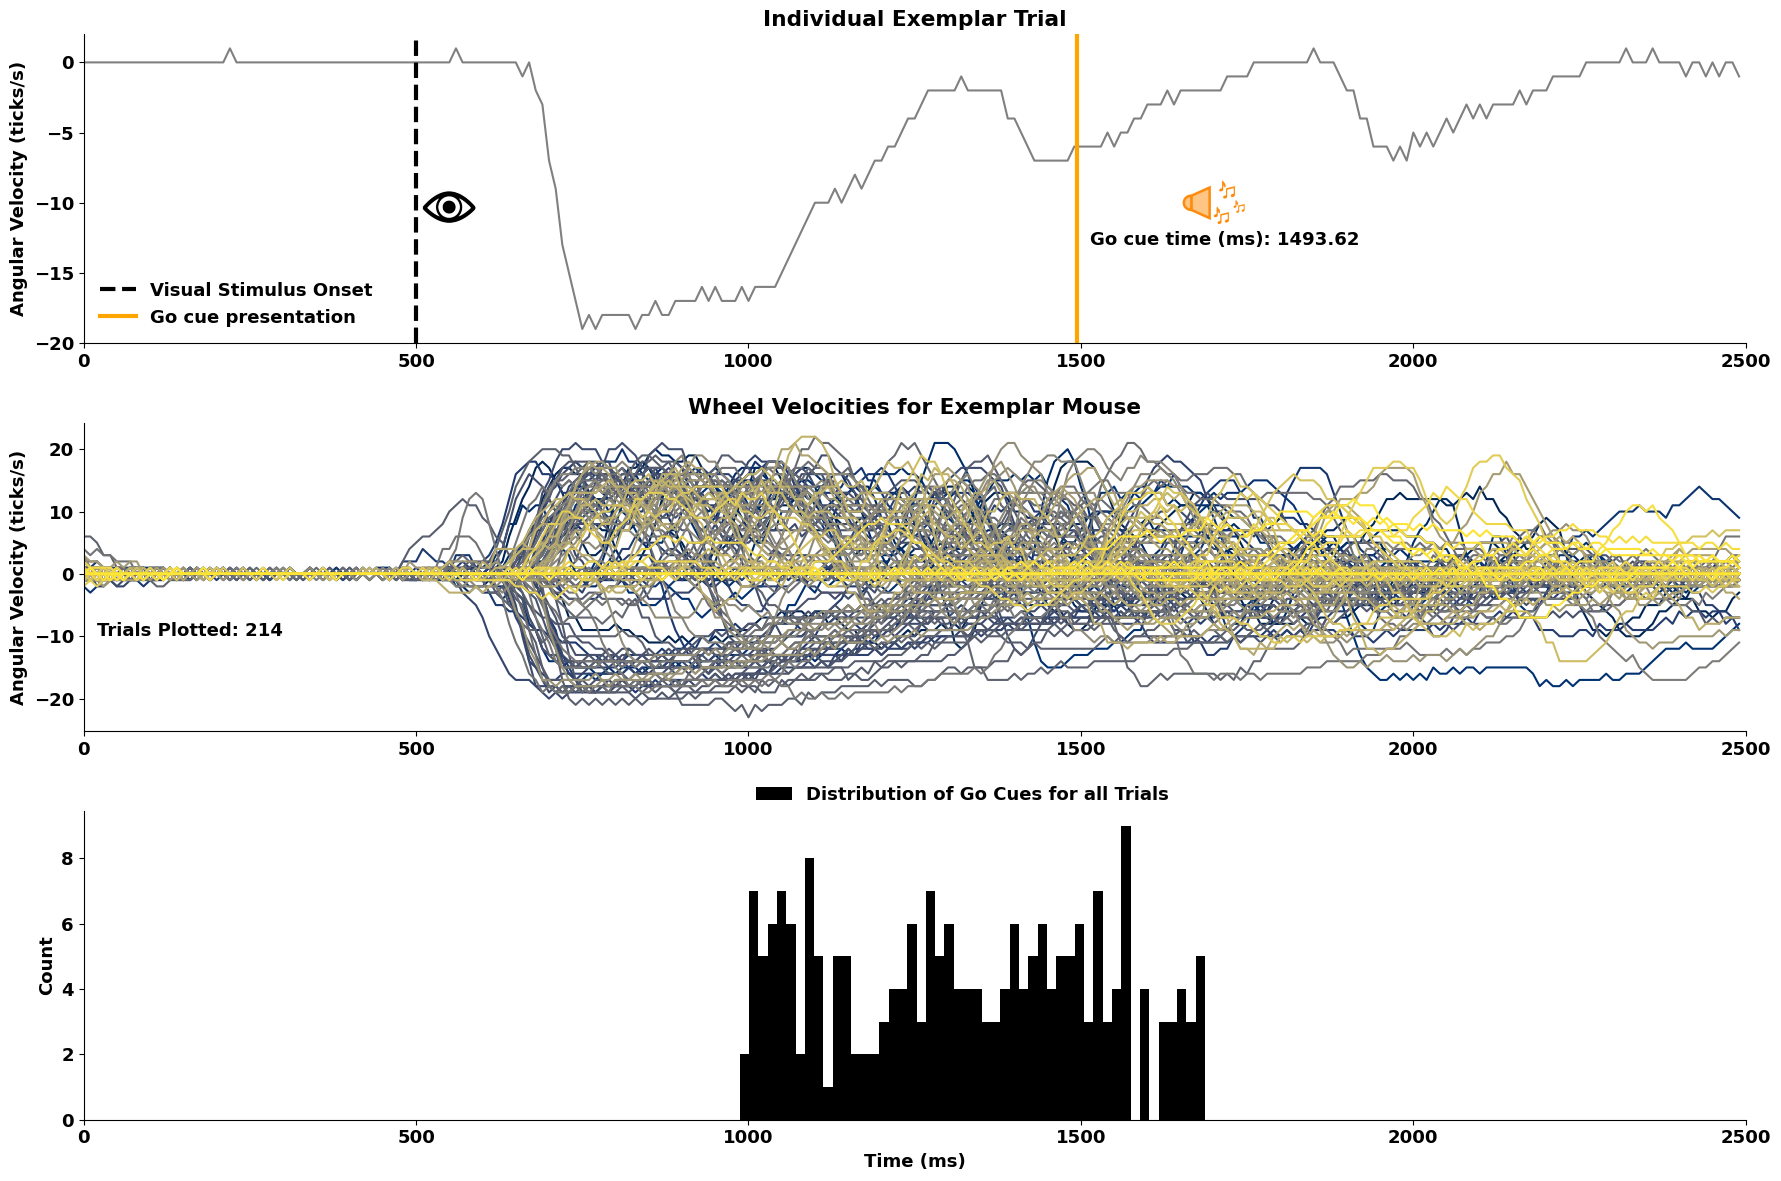

In [155]:
# Plotting
trials_plotted = 0
fig, axs = plt.subplots(3, figsize = (18,12))

#-- Calculating the stimulus response time --#
cur_mouse = 0
mouse_dict = alldat[cur_mouse]
wheel_vel = mouse_dict['wheel'][0] # In ticks/second

# Plotting all trials of our data
colors = [cm.cividis(x/len(wheel_vel)) for x in range(len(wheel_vel))]
for i in tqdm(range(len(mouse_dict['gocue']))):
    trials_plotted += 1
    axs[1].plot(np.arange(0, 2500, 10),wheel_vel[i], color = colors[i])

axs[1].set_title(f'Wheel Velocities for Exemplar Mouse', fontweight = 'bold')
axs[1].set_ylabel('Angular Velocity (ticks/s)', fontweight = 'bold')
axs[1].text(20,-10,f"Trials Plotted: {trials_plotted}")
axs[1].set_xlim(0,2500)


# Plotting the histogram of go cue (adding 500ms to go cues to correct for the time data)
axs[2].hist(mouse_dict['gocue']*1000+500, bins = 50, color = 'black', label = 'Distribution of Go Cues for all Trials');
axs[2].set_xlim(0,2500)
axs[2].set_ylabel('Count', fontweight = 'bold')
axs[2].legend(frameon=False, loc = (0.40,1));

# Plotting an individual trial with the go cue
indiv_trial_no = 30
axs[0].plot(np.arange(0, 2500, 10),wheel_vel[indiv_trial_no], color = 'gray')
axs[0].axvline(500, color = 'black', label = 'Visual Stimulus Onset', linewidth = 3, linestyle ='--')
axs[0].axvline(mouse_dict['gocue'][indiv_trial_no]*1000+500, color = 'orange', label = 'Go cue presentation', linewidth = 3)

axs[0].set_title(f"Individual Exemplar Trial", fontweight = 'bold')
axs[2].set_xlabel('Time (ms)', fontweight = 'bold')
axs[0].set_ylabel('Angular Velocity (ticks/s)', fontweight = 'bold')
axs[0].text(mouse_dict['gocue'][indiv_trial_no]*1000+520, -13,f"Go cue time (ms): {(round(mouse_dict['gocue'][indiv_trial_no][0],5)+.50)*1000}")
axs[0].set_xlim(0,2500)
axs[0].legend(frameon=False, loc = 'lower left');
plt.tight_layout()


#-- Sound --#
sound_x, sound_y = 1650, -15 # Note that coordinates aren't necessarily the center of the object
sound_size_x = 100
sound_size_y = 10
sound = axs[0].inset_axes([sound_x, sound_y, sound_size_x, sound_size_y], transform = axs[0].transData)
sound.imshow(dv.get_reward_icon(wheel.light_orange))
sound.axis("off")

#-- Visual Stimulus --#
sound_x, sound_y = 500, -15.5 # Note that coordinates aren't necessarily the center of the object
sound_size_x = 100
sound_size_y = 10
sound = axs[0].inset_axes([sound_x, sound_y, sound_size_x, sound_size_y], transform = axs[0].transData)
sound.imshow(dv.get_sight_icon(wheel.black))
sound.axis("off")

plt.savefig('Mouse_group_traj.png', dpi = 300)

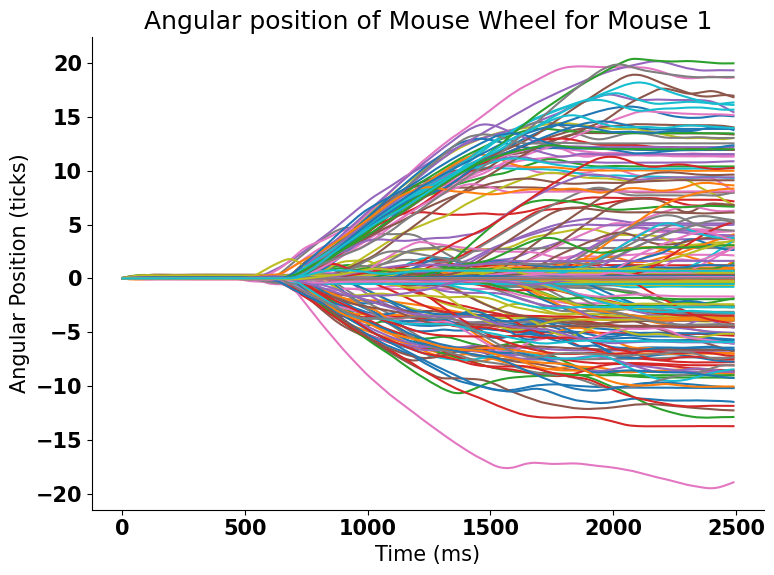

In [86]:

#-- Calculating the position from velocity --#

# We are interested in seeing whether initial velocity

cur_mouse_pos = 1
mouse_dict = alldat[cur_mouse_pos];
wheel_vel = mouse_dict['wheel'][0];# In deg, otherwise doesn't make any sense
wheel_pos = np.cumsum(wheel_vel/100, axis = 1) # correcting for units of time (velocities are binned at 10ms, we divide by 100 to get to angle/second)

# Plotting all our trajectory data
trials_plotted = 0
fig, ax = plt.subplots(figsize= (8,6))
for i in range(len(mouse_dict['gocue'])):
  if wheel_pos[i].mean():
    trials_plotted += 1
    ax.plot(np.arange(250)*10,wheel_pos[i])

ax.set_title(f"Angular position of Mouse Wheel for Mouse {str(cur_mouse_pos)}")
ax.set_ylabel('Angular Position (ticks)')
ax.set_xlabel('Time (ms)');


#### Angular Position Data

> Indented block



In [11]:
#-- Printing the total number of trial for each mouse -- #

total_trials = 0
for i, mouse in enumerate(alldat):
  mouse_dict = alldat[i]
  if i <5:
    print(f"Number of trials for mouse = {i}",len(mouse_dict['gocue']))
  total_trials += len(mouse_dict['gocue'])

print('The total number of trials: ', total_trials)

# from the paper it seems like the mice just did as many trials as they could

Number of trials for mouse = 0 214
Number of trials for mouse = 1 251
Number of trials for mouse = 2 228
Number of trials for mouse = 3 249
Number of trials for mouse = 4 254
The total number of trials:  10050


### Reaction Times of Mice Relative to the Go-Cue

Text(0.5, 0, 'Reaction Time (s)')

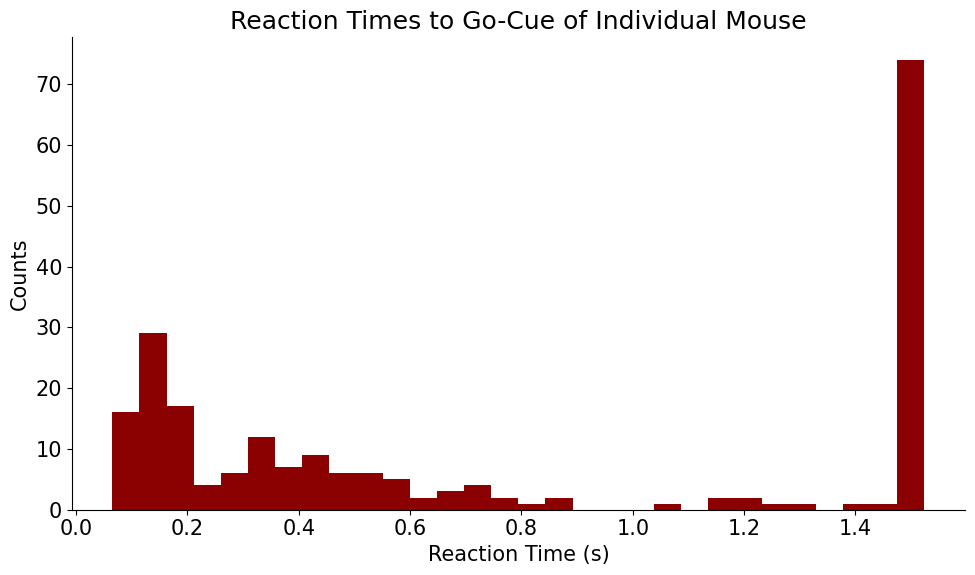

In [12]:
# Individual Reaction time
mouse_dict = alldat[0]
reaction_times = mouse_dict['response_time'] - mouse_dict['gocue']

fig, ax = plt.subplots(figsize = (10,6))
ax.hist(reaction_times, bins = 30, color = 'darkred');
ax.set_title('Reaction Times to Go-Cue of Individual Mouse')
ax.set_ylabel('Counts')
ax.set_xlabel('Reaction Time (s)')

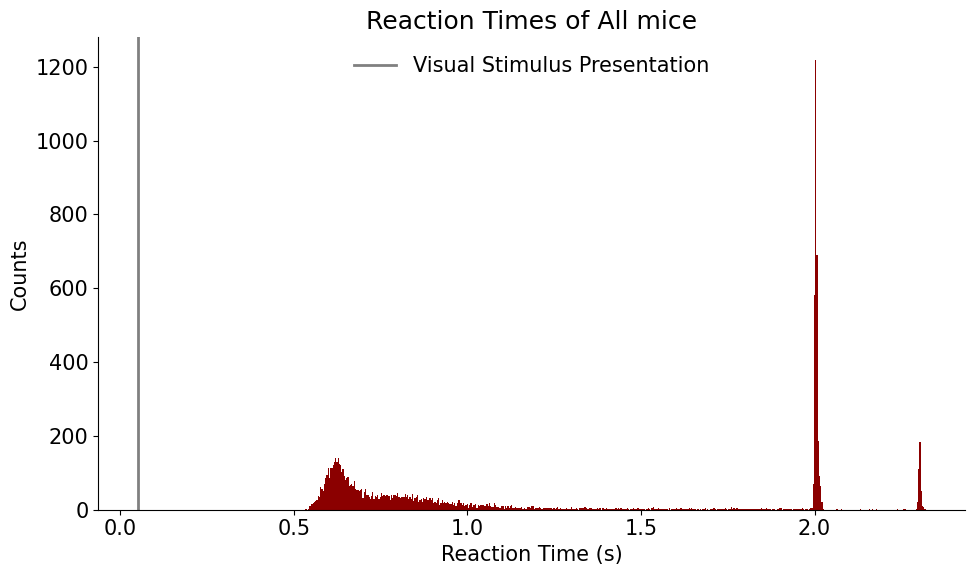

In [13]:
# Average reaction time of mice from go cue
mice_rxn_times = []
for i, mouse in enumerate(alldat):
  mouse_dict = alldat[i]
  reaction_times = mouse_dict['response_time'] - mouse_dict['gocue'] + .50
  mice_rxn_times.append(reaction_times)

# concatenating all our mice reaction times
mice_rxn_times = np.concatenate(mice_rxn_times, axis = 0)

# plotting our reaction times
fig, ax = plt.subplots(figsize = (10,6))
ax.hist(mice_rxn_times, bins = 500, color = 'darkred');
ax.set_title('Reaction Times of All mice')
ax.set_ylabel('Counts')
ax.set_xlabel('Reaction Time (s)')
ax.axvline(0.05, linewidth = 2, color = 'gray', label = 'Visual Stimulus Presentation')
ax.legend(frameon=False)

# Plot the average 'go-cue' time location
all_gos = alldat

## Deteriming Movement Onset for Each Mouse, for each trial

In [14]:
#-- Calculating movement onset time --#

###Collecting all of our velocity data###

# Creating a wheel velocity dictionary for every mouse
mouse_vels = {}
for i in range(len(alldat)):
  mouse_dict = alldat[i]
  wheel_vel = mouse_dict['wheel'][0]
  mouse_vels[f"mouse{i}"] = wheel_vel

def movement_onset(mouse_vels, main_time = 100, stds = 3, time_buffer = 10):
  """Takes in an array of velocity data, and returns the index of movement onset,
  using a dual threshold method. Movement onset is calculated by taking the noise
  baseline as first 500ms of data before stimulus presentation (in the Steinmetz data set),
  and then searching the data for the absolute value of the first velocity that exceeds
  the mean absolute value baseline by n 'stds' (first threshold).
  In order for this to be considered a valid onset, the velocity above baseline
  must be maintained for 'main_time' (our second threshold.).

  Args:
    mouse_vels, dictionary of wheel velocity data for every mouse. Items in the dictionary
      are the wheel velocities binned every 10ms.
    stds, float, the number of standard deviations above baseline for the first threshold.
    main_time, float, the time window in ms of the second threshold.
    time_buffer, int, the number of data points after visual stimulus we exclude from
      our onset detection. We exclude data because we don't want to include false,
      or reflexive movements.
  Returns:
    onset_indices, dictionary, will return the movement onset indicies for each mouse,
      as a 1D array with the same dimensionality as the number of trials. The indices correspond to
      the 10 ms bins that the mouse velocity data contains.
  """

  # Initializingg our dual threshold method
  print("Number of std's above baseline for first threshold: ", stds)
  datapoints_to_check = int(main_time/10) # divide by 10, because timebins are 10ms
  print('Number of data points for second threshold: ', datapoints_to_check)

  # Selecting a time window buffer.
  time_buffer = 10 # number of data points (points * 10 = ms)

  # Constructing our dictionary of mice from the keys in the incoming dictionary of mice
  onset_indices = {mouse_key: [] for mouse_key in mouse_vels.keys()}

  # Calculating our baseline movement information for the all mice:
  all_mouse_data = np.concatenate([mouse_vels[mouse] for mouse in mouse_vels.keys()], axis = 0)
  trial_baseline_means = np.mean(np.abs(all_mouse_data[:, :50]), axis = 0) # taking abs to rectify our movement signals
  print(trial_baseline_means)
  baseline_avg_abs = np.abs(np.mean(trial_baseline_means))
  print(baseline_avg_abs)
  baseline_std_avg = np.abs(np.std(trial_baseline_means))

  for mouse in tqdm(mouse_vels.keys()):
    cur_mouse = mouse_vels[mouse]

    # Iterating through every trial for each mouse
    for trial_idx in range(cur_mouse.shape[0]):

      # Setting our pointers
      cur_trial = cur_mouse[trial_idx, :]
      stored_idx = 0 # re/setting a pointer for a potential onset index

      # Calculating our baseline movement information for the current trial:
      # baseline = np.abs(cur_trial[:50]) # taking abs to rectify out baseline
      post_vis_stimulus =  cur_trial[50+time_buffer:-1]
      # baseline_avg_abs = np.abs(baseline.mean())
      # baseline_std_avg = np.abs(np.std(baseline))

      #-- Implementing our dual-threshold algorithm --#
      found_index = False # found_index flag
      for idx, vel in enumerate(post_vis_stimulus):
        if np.abs(vel) > (baseline_avg_abs + stds*baseline_std_avg):
          stored_vel = post_vis_stimulus[idx]
          stored_idx = idx
          num_trials_maintained = 0 # initializing our counter

          # Checking to see if our threshold has been maintained long enough
          for vel in post_vis_stimulus[stored_idx:stored_idx + datapoints_to_check]:
              if stored_vel > 0:
                if vel > (baseline_avg_abs + stds*baseline_std_avg):
                  num_trials_maintained += 1
              elif stored_vel < 0:
                if vel < -(baseline_avg_abs + stds*baseline_std_avg):
                  num_trials_maintained += 1


              # If maintained, we store the index for that trial
              if num_trials_maintained == datapoints_to_check:
                onset_indices[mouse].append(stored_idx + 50 + time_buffer) # we adde 50 to compensate for the baseline period that we removed
                found_index = True
                break

        if found_index == True:
          break
        elif stored_idx + datapoints_to_check > len(post_vis_stimulus):
          break

      # appending a NaN to the onset indices to track a failure to detect
      if found_index == False:
        onset_indices[mouse].append(float("NaN"))


  # Calculating the number of 'NaNs' (failures to detect movement onset)
  num_of_nans = 0
  for key in onset_indices:
    num_of_nans += sum(math.isnan(x) for x in onset_indices[key])
  print("Total Failures to detect onset: ", num_of_nans)

  return onset_indices

onset_indices = movement_onset(mouse_vels, stds = 2, main_time = 100, time_buffer = 12)

Number of std's above baseline for first threshold:  2
Number of data points for second threshold:  10
[0.27820896 0.26348259 0.24825871 0.22935323 0.21741294 0.20069652
 0.18865672 0.17870647 0.16766169 0.15044776 0.14935323 0.12895522
 0.12159204 0.11233831 0.10616915 0.09761194 0.0881592  0.08437811
 0.07412935 0.06895522 0.06746269 0.05681592 0.06039801 0.05014925
 0.04965174 0.04975124 0.04238806 0.04099502 0.03761194 0.0360199
 0.03502488 0.03621891 0.03412935 0.03114428 0.03074627 0.03094527
 0.02975124 0.03074627 0.03124378 0.02895522 0.03084577 0.0281592
 0.03223881 0.03164179 0.03691542 0.04199005 0.05781095 0.06378109
 0.08109453 0.10079602]
0.08939900497512437


  0%|          | 0/39 [00:00<?, ?it/s]

Total Failures to detect onset:  1876


onset indices for trial:  68
Value at index:  -1.0
Wheel Velocities for the mouse's given trial:  
 [  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.  -1.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   1.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   1.  -1.   0.   0.   0.   0.   1.   1.   2.   2.   4.   4.   5.   5.
   4.   3.   1.  -3.  -6. -11. -12. -11.  -9.  -5.  -3.   0.   0.   0.
   1.  -1.  -1.  -1.  -2.  -3.  -3.  -4.  -5.  -4.  -5.  -5.  -5.  -5.
  -5.  -5.  -5.  -5.  -5.  -5.  -4.  -3.  -3.  -3.  -2.  -2.  -2.  -2.
  -4.  -6.  -8.  -9.  -9.  -8.  -8.  -6.  -7.  -

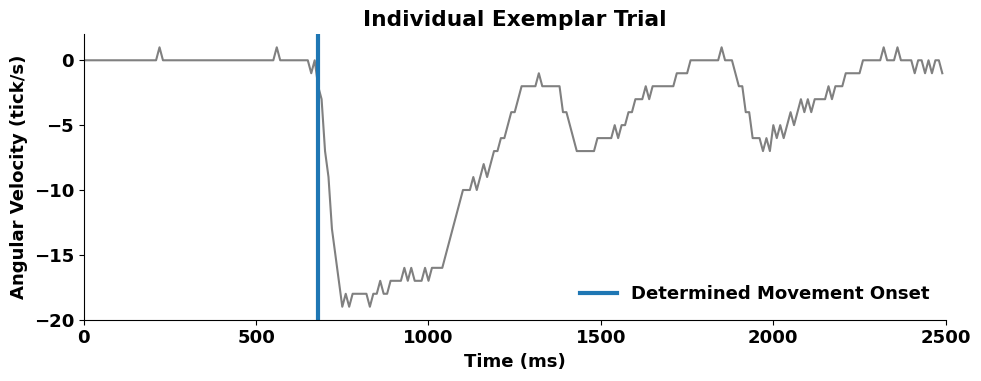

In [164]:
# Plotting individual trials with movement onset, to pass 'eye test'
cur_mouse = 0
fig, ax = plt.subplots(figsize = (10,4))
mouse_dict = alldat[cur_mouse]
wheel_vel = mouse_dict['wheel'][0] # in degrees, radians would be way too fast

# Plotting an individual trial with where we detected movement onset
indiv_trial_no = 30
ax.plot(np.arange(0, 2500, 10),wheel_vel[indiv_trial_no], color = 'gray')

# Plotting our movement onset loction from 'onset_indices'
mouse_onsets = onset_indices[f"mouse{cur_mouse}"]
ax.axvline(mouse_onsets[indiv_trial_no]*10, linewidth = 3, label = 'Determined Movement Onset') # multiply by 10 to get in unites of ms (since sample period was 10 ms)

# Plot formatting
# ax.set_title(f"Individual Trial {indiv_trial_no}")
ax.set_title(f"Individual Exemplar Trial", fontweight = 'bold')
ax.set_xlabel('Time (ms)', fontweight = 'bold')
ax.set_ylabel('Angular Velocity (tick/s)', fontweight = 'bold')
ax.set_xlim(0,2500)
ax.legend(frameon = False)

print("onset indices for trial: ", mouse_onsets[indiv_trial_no])

print("Value at index: ", wheel_vel[6][65])
print("Wheel Velocities for the mouse's given trial:  \n", wheel_vel[6])

plt.savefig('IndividualExemplarTrial.png', dpi = 300)

## Steinmetz Analysis (from Neuromatch)

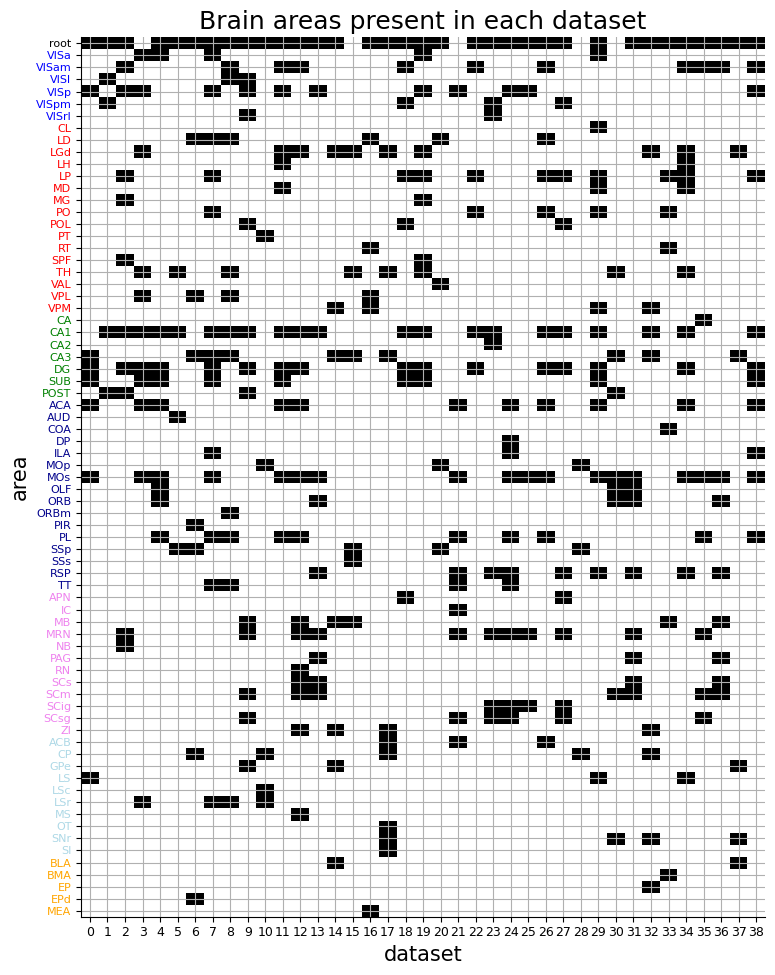

In [ ]:
# Make a plot of which brain areas are present in each dataset
# note that region 4 ("other ctx" are neurons that were not able to be classified)
# region 4 does not correspond to brain_group 4, which are all cortical neurons outside of visual cortex
regions = ["vis ctx", "thal", "hipp", "other ctx", "midbrain", "basal ganglia", "cortical subplate", "other"]
region_colors = ['blue', 'red', 'green', 'darkblue', 'violet', 'lightblue', 'orange', 'gray']
brain_groups = [["VISa", "VISam", "VISl", "VISp", "VISpm", "VISrl"],  # visual cortex
                ["CL", "LD", "LGd", "LH", "LP", "MD", "MG", "PO", "POL", "PT", "RT", "SPF", "TH", "VAL", "VPL", "VPM"], # thalamus
                ["CA", "CA1", "CA2", "CA3", "DG", "SUB", "POST"],  # hippocampal
                ["ACA", "AUD", "COA", "DP", "ILA", "MOp", "MOs", "OLF", "ORB", "ORBm", "PIR", "PL", "SSp", "SSs", "RSP","TT"],  # non-visual cortex
                ["APN", "IC", "MB", "MRN", "NB", "PAG", "RN", "SCs", "SCm", "SCig", "SCsg", "ZI"],  # midbrain
                ["ACB", "CP", "GPe", "LS", "LSc", "LSr", "MS", "OT", "SNr", "SI"],  # basal ganglia
                ["BLA", "BMA", "EP", "EPd", "MEA"]  # cortical subplate
                ]

# Assign each area an index
area_to_index = dict(root=0)
counter = 1
for group in brain_groups:
    for area in group:
        area_to_index[area] = counter
        counter += 1

# Figure out which areas are in each dataset
areas_by_dataset = np.zeros((counter, len(alldat)), dtype=bool)
for j, d in enumerate(alldat):
    for area in np.unique(d['brain_area']):
        i = area_to_index[area]
        areas_by_dataset[i, j] = True

# Show the binary matrix
plt.figure(figsize=(8, 10))
plt.imshow(areas_by_dataset, cmap="Greys", aspect="auto", interpolation="none")

# Label the axes
plt.xlabel("dataset")
plt.ylabel("area")

# Add tick labels
yticklabels = ["root"]
for group in brain_groups:
  yticklabels.extend(group)
plt.yticks(np.arange(counter), yticklabels, fontsize=8)
plt.xticks(np.arange(len(alldat)), fontsize=9)

# Color the tick labels by region
ytickobjs = plt.gca().get_yticklabels()
ytickobjs[0].set_color("black")
counter = 1
for group, color in zip(brain_groups, region_colors):
  for area in group:
    ytickobjs[counter].set_color(color)
    counter += 1

plt.title("Brain areas present in each dataset")
plt.grid(True)
plt.show()

dict_keys(['spks', 'wheel', 'pupil', 'response', 'response_time', 'bin_size', 'stim_onset', 'contrast_right', 'contrast_left', 'brain_area', 'feedback_time', 'feedback_type', 'gocue', 'mouse_name', 'date_exp', 'trough_to_peak', 'active_trials', 'contrast_left_passive', 'contrast_right_passive', 'spks_passive', 'pupil_passive', 'wheel_passive', 'prev_reward', 'ccf', 'ccf_axes', 'cellid_orig', 'reaction_time', 'face', 'face_passive', 'licks', 'licks_passive'])


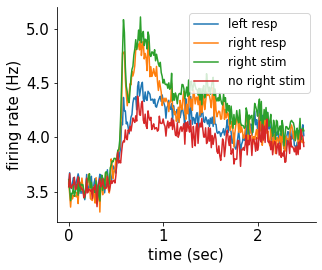

In [ ]:
# @title Basic plots of population average

# select just one of the recordings here. 11 is nice because it has some neurons in vis ctx.
dat = alldat[11]
print(dat.keys())

dt = dat['bin_size']  # binning at 10 ms
NT = dat['spks'].shape[-1]

ax = plt.subplot(1, 5, 1)
response = dat['response']  # right - nogo - left (-1, 0, 1)
vis_right = dat['contrast_right']  # 0 - low - high
vis_left = dat['contrast_left']  # 0 - low - high
plt.plot(dt * np.arange(NT), 1/dt * dat['spks'][:, response >= 0].mean(axis=(0, 1)))  # left responses
plt.plot(dt * np.arange(NT), 1/dt * dat['spks'][:, response < 0].mean(axis=(0, 1)))  # right responses
plt.plot(dt * np.arange(NT), 1/dt * dat['spks'][:, vis_right > 0].mean(axis=(0, 1)))  # stimulus on the right
plt.plot(dt * np.arange(NT), 1/dt * dat['spks'][:, vis_right == 0].mean(axis=(0, 1)))  # no stimulus on the right

plt.legend(['left resp', 'right resp', 'right stim', 'no right stim'], fontsize=12)
ax.set(xlabel='time (sec)', ylabel='firing rate (Hz)')
plt.show()

In [ ]:
nareas = 4  # only the top 4 regions are in this particular mouse
NN = len(dat['brain_area'])  # number of neurons
barea = nareas * np.ones(NN, )  # last one is "other"
for j in range(nareas):
  barea[np.isin(dat['brain_area'], brain_groups[j])] = j  # assign a number to each region

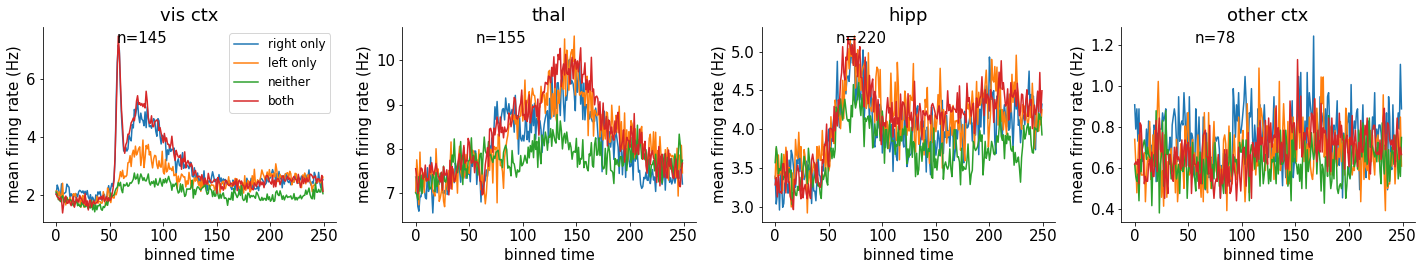

In [ ]:
# @title plots by brain region and visual conditions
for j in range(nareas):
  ax = plt.subplot(1, nareas, j + 1)

  plt.plot(1/dt * dat['spks'][barea==j][:, np.logical_and(vis_left == 0, vis_right > 0)].mean(axis=(0, 1)))
  plt.plot(1/dt * dat['spks'][barea==j][:, np.logical_and(vis_left > 0, vis_right == 0)].mean(axis=(0, 1)))
  plt.plot(1/dt * dat['spks'][barea==j][:, np.logical_and(vis_left == 0, vis_right == 0)].mean(axis=(0, 1)))
  plt.plot(1/dt * dat['spks'][barea==j][:, np.logical_and(vis_left > 0, vis_right > 0)].mean(axis=(0, 1)))
  plt.text(.25, .92, 'n=%d'%np.sum(barea == j), transform=ax.transAxes)

  if j==0:
    plt.legend(['right only', 'left only', 'neither', 'both'], fontsize=12)
  ax.set(xlabel='binned time', ylabel='mean firing rate (Hz)', title=regions[j])
plt.show()

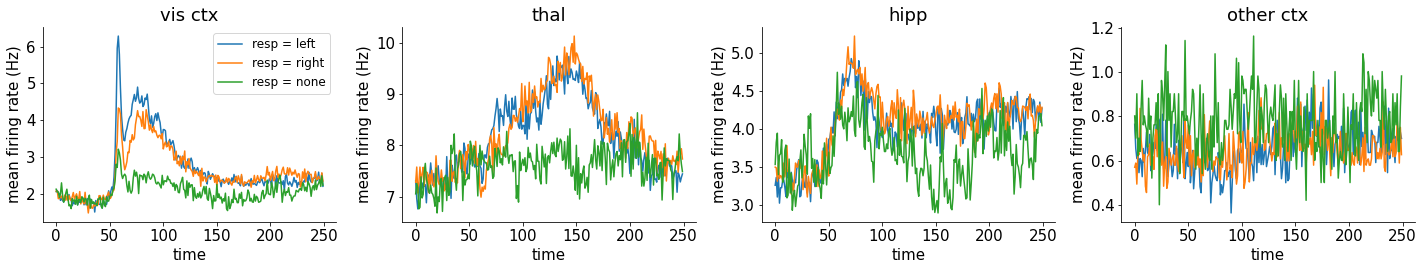

In [ ]:
# @title plots by brain region and response type
for j in range(nareas):
  ax = plt.subplot(1, nareas, j + 1)
  plt.title(regions[j])
  if np.sum(barea == j) == 0:
    continue
  plt.plot(1/dt * dat['spks'][barea == j][:, response < 0].mean(axis=(0, 1)))
  plt.plot(1/dt * dat['spks'][barea == j][:, response > 0].mean(axis=(0, 1)))
  plt.plot(1/dt * dat['spks'][barea == j][:, response == 0].mean(axis=(0, 1)))

  if j == 0:
    plt.legend(['resp = left', 'resp = right', 'resp = none'], fontsize=12)
  ax.set(xlabel='time', ylabel='mean firing rate (Hz)')
plt.show()